In [1]:
import datetime
import matplotlib.pyplot as plt
import os
import pandas as pd
import plotly.express as px
import re
import requests
import zipfile

from datetime import datetime, timedelta


In [2]:
pip install pandas-ta


[notice] A new release of pip available: 22.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import yfinance as yf
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# Step 1: Download data for ECH
fund_ticker = "ECH"
data = yf.download(fund_ticker, start="2015-01-01", end="2025-01-01")

# Check if data was retrieved
if data.empty:
    raise ValueError("No data was retrieved for the given ticker and date range.")

# Step 2: Ensure data includes relevant columns and reset index
data.reset_index(inplace=True)
data

[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
Ticker,,ECH,ECH,ECH,ECH,ECH
0,2015-01-02,29.007076,29.360372,28.911391,29.308850,257000
1,2015-01-05,28.484491,28.948193,28.469770,28.815707,355800
2,2015-01-06,28.403532,28.712665,28.359369,28.521297,262300
3,2015-01-07,28.543371,28.727380,28.521291,28.609614,373700
4,2015-01-08,28.734743,28.852508,28.646417,28.778903,139900
...,...,...,...,...,...,...
2511,2024-12-24,25.129999,25.209999,25.020000,25.020000,58400
2512,2024-12-26,25.090000,25.240000,25.030001,25.049999,84000
2513,2024-12-27,25.139999,25.250000,25.030001,25.070000,153600


Overall Correlation (Open vs Close): 1.00

K-Fold Correlation Results:
   Fold  Correlation (Open vs Close)
0     1                     0.998456
1     2                     0.998097
2     3                     0.998182
3     4                     0.998435
4     5                     0.998075


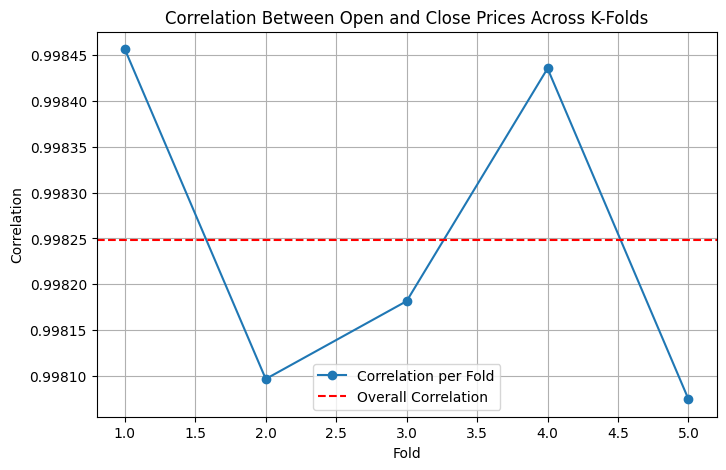

In [4]:
# Flatten MultiIndex if necessary
if isinstance(data.columns, pd.MultiIndex):
    data.columns = [col[0] for col in data.columns]  # Extract first level of MultiIndex

# Select relevant columns
data = data[["Date", "Open", "High", "Low", "Close", "Volume"]]

# Ensure 'Open' and 'Close' are valid Series
if not isinstance(data["Open"], pd.Series) or not isinstance(data["Close"], pd.Series):
    raise TypeError("Columns 'Open' and 'Close' are not valid Pandas Series.")

# Convert to numeric (handling any potential string or NaN values)
data["Open"] = pd.to_numeric(data["Open"], errors="coerce")
data["Close"] = pd.to_numeric(data["Close"], errors="coerce")

# Step 3: Drop rows with missing values (if any)
data.dropna(inplace=True)

# Step 4: Calculate overall correlation (Open vs Close)
overall_correlation = data["Open"].corr(data["Close"])
print(f"Overall Correlation (Open vs Close): {overall_correlation:.2f}")

# Step 5: Implement k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation
correlation_results = []

# Perform cross-validation
for train_index, test_index in kf.split(data):
    test_data = data.iloc[test_index]
    
    # Ensure the test data has enough rows
    if len(test_data) > 1:
        corr = test_data["Open"].corr(test_data["Close"])
        correlation_results.append(corr)
    else:
        correlation_results.append(None)

# Step 6: Create a results table
results_table = pd.DataFrame({
    "Fold": range(1, len(correlation_results) + 1),
    "Correlation (Open vs Close)": correlation_results
})

# Print the table
print("\nK-Fold Correlation Results:")
print(results_table)

# Step 7: Visualize the results
plt.figure(figsize=(8, 5))
plt.plot(results_table["Fold"], results_table["Correlation (Open vs Close)"], marker='o', label='Correlation per Fold')
plt.axhline(y=overall_correlation, color='r', linestyle='--', label='Overall Correlation')
plt.title('Correlation Between Open and Close Prices Across K-Folds')
plt.xlabel('Fold')
plt.ylabel('Correlation')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
pip install yfinance


[notice] A new release of pip available: 22.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import yfinance as yf
import numpy as np

# Step 1: Download ETF Data
def download_etf_data(ticker, start_date, end_date):
    """
    Download historical ETF data using yfinance.
    """
    data = yf.download(ticker, start=start_date, end=end_date)
    data.reset_index(inplace=True)
    return data

# Download ECH data
ticker = "ECH"
data = download_etf_data(ticker, start_date="2015-01-01", end_date="2025-01-01")

# Preview data
print(data.head())

data.to_csv("ech_data.csv", index=False)

[*********************100%***********************]  1 of 1 completed

Price        Date      Close       High        Low       Open  Volume
Ticker                   ECH        ECH        ECH        ECH     ECH
0      2015-01-02  29.007076  29.360372  28.911391  29.308850  257000
1      2015-01-05  28.484491  28.948193  28.469770  28.815707  355800
2      2015-01-06  28.403532  28.712665  28.359369  28.521297  262300
3      2015-01-07  28.543371  28.727380  28.521291  28.609614  373700
4      2015-01-08  28.734743  28.852508  28.646417  28.778903  139900


In [7]:
with zipfile.ZipFile('tweets.zip', 'r') as zip_ref:
    zip_ref.extractall('extracted_tweets')

tweets_folder = 'extracted_tweets/tweets'
csv_files = [f for f in os.listdir(tweets_folder) if f.endswith('.csv')]

# Loop through CSV files and read them into DataFrames
dfs = []
for csv_file in csv_files:
    file_path = os.path.join(tweets_folder, csv_file)
    df = pd.read_csv(file_path, sep=';')

    if 'full_text' in df.columns:
        df = df.rename(columns={'full_text': 'tweet_text'})
    elif 'text' in df.columns:
        df = df.rename(columns={'text': 'tweet_text'})

    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame and display it
twitter_df = pd.concat(dfs, ignore_index=True)
twitter_df

,id,created_at,tweet_text,sentiment
0,77522,2020-04-15 01:03:46+00:00,"RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...",positive
1,661634,2020-06-25 06:20:06+00:00,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,negative
2,413231,2020-06-04 15:41:45+00:00,Net issuance increases to fund fiscal programs...,positive
3,760262,2020-07-03 19:39:35+00:00,RT @bentboolean: How much of Amazon's traffic ...,positive
4,830153,2020-07-09 14:39:14+00:00,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,positive
...,...,...,...,...
928668,938668,2020-07-16 00:00:25+00:00,RT @MadMraket: We tend to spend lot of time in...,NaN
928669,938669,2020-07-16 00:00:23+00:00,You \n\n$SPX $SPY #ES_F,NaN
928670,938670,2020-07-16 00:00:23+00:00,"$KO Coca-Cola #Options #maxpain Chart, Open In...",NaN
928671,938671,2020-07-16 00:00:06+00:00,Here's a dividends watchlist \nfor the 01/04/0...,NaN


In [8]:
twitter_df['created_at'] = pd.to_datetime(twitter_df['created_at']).dt.tz_convert('America/New_York')
# Create a DataFrame containing only retweets
retweets_df = twitter_df[twitter_df['tweet_text'].str.startswith('RT')]

# Create a DataFrame containing tweets that are not retweets
remainder_df = twitter_df[~twitter_df['tweet_text'].str.startswith('RT')]

# Display the DataFrames
print("## Retweets DataFrame:")
print("This DataFrame contains only retweets from the Twitter data.")
display(retweets_df)

print("\n## Remainder DataFrame:")
print("This DataFrame contains tweets that are not retweets.")
display(remainder_df)

## Retweets DataFrame:
This DataFrame contains only retweets from the Twitter data.


,id,created_at,tweet_text,sentiment
0,77522,2020-04-14 21:03:46-04:00,"RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...",positive
3,760262,2020-07-03 15:39:35-04:00,RT @bentboolean: How much of Amazon's traffic ...,positive
5,27027,2020-04-12 17:52:56-04:00,RT @QuantTrend: Reduce your portfolio RISK! GO...,positive
7,392845,2020-06-01 21:12:29-04:00,RT @ArjunKharpal: #Apple has cut the prices of...,negative
8,313771,2020-05-07 00:58:41-04:00,RT @SMA_alpha: The #CDC U.S. New Case data has...,negative
...,...,...,...,...
928659,938659,2020-07-15 20:01:05-04:00,RT @tradewithdough: #India is adding millions ...,NaN
928662,938662,2020-07-15 20:00:57-04:00,RT @WarlusTrades: $SPX SPY #ES_F #AMD\n\n⚠️ Co...,NaN
928664,938664,2020-07-15 20:00:42-04:00,RT @BerkshireCapGrp: MEDH GAP FILLED. TIME TO ...,NaN
928667,938667,2020-07-15 20:00:26-04:00,RT @CoronaStocks: Boeing is Facing Major Headw...,NaN



## Remainder DataFrame:
This DataFrame contains tweets that are not retweets.


,id,created_at,tweet_text,sentiment
1,661634,2020-06-25 02:20:06-04:00,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,negative
2,413231,2020-06-04 11:41:45-04:00,Net issuance increases to fund fiscal programs...,positive
4,830153,2020-07-09 10:39:14-04:00,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,positive
6,472959,2020-06-09 01:23:06-04:00,$863.69 Million in Sales Expected for Spirit A...,positive
9,267894,2020-05-04 11:16:29-04:00,Where to Look for Dependable Dividends\nRead M...,neutral
...,...,...,...,...
928666,938666,2020-07-15 20:00:32-04:00,Real-Time Data Recovery Stalled Amid COVID-19 ...,NaN
928669,938669,2020-07-15 20:00:23-04:00,You \n\n$SPX $SPY #ES_F,NaN
928670,938670,2020-07-15 20:00:23-04:00,"$KO Coca-Cola #Options #maxpain Chart, Open In...",NaN
928671,938671,2020-07-15 20:00:06-04:00,Here's a dividends watchlist \nfor the 01/04/0...,NaN


In [9]:
# Get weekly tweet counts
weekly_counts = twitter_df.set_index('created_at').resample('W-MON', label='left', closed='left').count()
weekly_counts = weekly_counts.rename_axis(index="Week Starting")
display(weekly_counts)

,id,tweet_text,sentiment
Week Starting,,,
2020-04-06 00:00:00-04:00,33291,33291,39
2020-04-13 00:00:00-04:00,90678,90678,143
2020-04-20 00:00:00-04:00,84788,84788,106
2020-04-27 00:00:00-04:00,52106,52106,71
2020-05-04 00:00:00-04:00,70438,70438,90
2020-05-11 00:00:00-04:00,0,0,0
2020-05-18 00:00:00-04:00,0,0,0
2020-05-25 00:00:00-04:00,35982,35982,53
2020-06-01 00:00:00-04:00,75666,75666,100


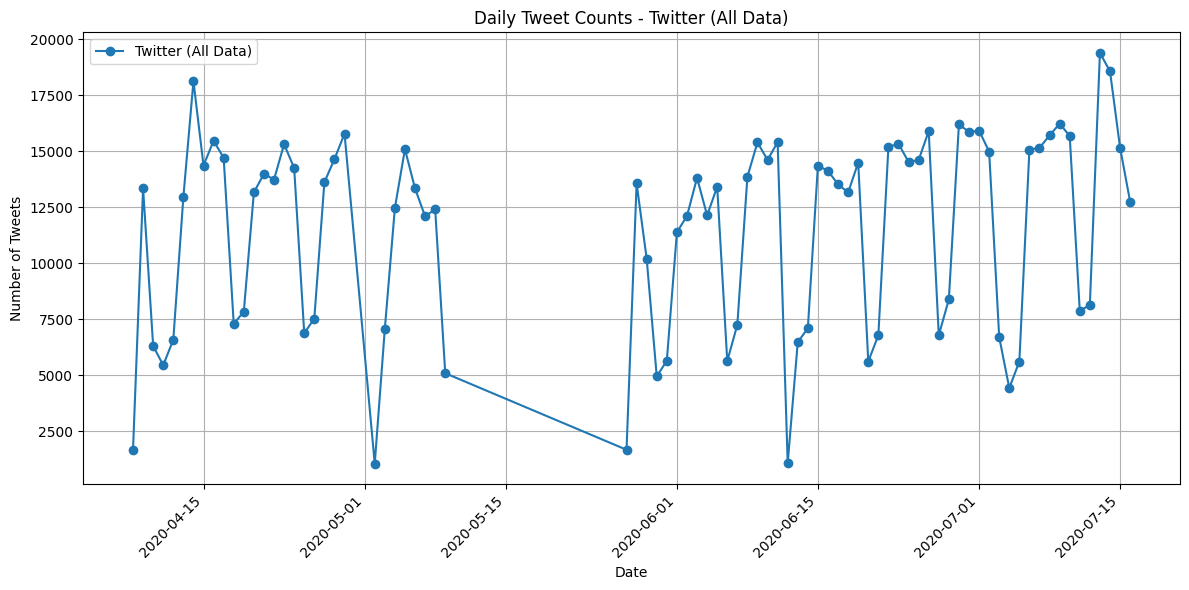

In [10]:
daily_tweet_counts_twitter_all = twitter_df.groupby(twitter_df['created_at'].dt.date)['tweet_text'].count()

# Plotting
plt.figure(figsize=(12, 6))

plt.plot(daily_tweet_counts_twitter_all.index, daily_tweet_counts_twitter_all.values, label='Twitter (All Data)', marker='o')

plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Daily Tweet Counts - Twitter (All Data)')
plt.legend()
plt.grid(True)

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


In [11]:
# Discover stock symbols and hashtags
twitter_df['cashtags_hashtags'] = twitter_df['tweet_text'].str.findall(r'(?:\$|#)([a-zA-Z]+\.*[a-zA-Z]+)')
twitter_df.explode('cashtags_hashtags')['cashtags_hashtags'].str.lower().value_counts().sort_values(ascending=False).head(10)

cashtags_hashtags
stocks         262381
spx            190857
aapl           123629
spy            115031
amzn           108484
fb              85685
es              66068
stockmarket     65091
msft            62018
trading         60261
Name: count, dtype: int64

In [ ]:
# Define a function to check for S&P 500 mentions with variations
def contains_spy(text):
    # Handle variations in spacing, "&", and case
    text = text.lower()  # Convert to lowercase for case-insensitive matching
    text = re.sub(r"[^a-zA-Z0-9 ]", "", text)  # Remove special characters except spaces

    # Check for different patterns
    patterns = [
        r"\bspy\b",  # Using word boundaries (\b) to avoid capturing part of word (e.g. "spying")
        r"\$spy",  # Cashtag
        r"#spy",  # Hashtag
        r"\b\$spy\b",  # Cashtag with word boundaries
        r"\b#spy\b",  # Hashtag with word boundaries
        r"\bspdr\b",  # Full name part using word boundaries
        r"\bs\&p 500 etf\b",  # Full name part with variations using word boundaries
        r"\bs\&p500 etf\b",  # Full name part with variations using word boundaries
        r"\bsp500 etf\b"  # Full name part with variations using word boundaries
        r"\bspy etf\b"  # Full name part with variations using word boundaries
        # ...add more variations as needed...
    ]

    return any(re.search(pattern, text) for pattern in patterns)

# Apply the function to filter the DataFrame and display it
filtered_twitter_df = twitter_df[twitter_df['tweet_text'].apply(contains_spy)]
filtered_twitter_df